In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-06-24 12:20:20


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.pmaps_functions as pm
from   invisible_cities.reco.params           import S12Params 
from   invisible_cities.reco.params           import CalibVectors
from   invisible_cities.reco.params           import DeconvParams
from   invisible_cities.reco.params           import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.core.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12


In [4]:
import invisible_cities.reco.event_model as evm
from invisible_cities.core.ic_types import minmax

In [5]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [6]:
run_number = 3882
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [7]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [9]:
from invisible_cities.reco.dst_functions  import load_dst

In [10]:
input_files = ['/Users/jjgomezcadenas/Projects/IC/invisible_cities/database/test_data/dst_3389_test.h5']

In [12]:
dsts = [load_dst(input_file, 'DST', 'Events')
                for input_file in input_files]

In [13]:
dsts


[   event          time  peak  nS2    S1w       S1h       S1e       S1t  \
 0      4  1.490299e+09     0    1  250.0  1.428076  8.223267  486350.0   
 
         S2w          S2h  ...        S2t  Nsipm        DT         Z      X  \
 0  9.430625  1040.561646  ...   653012.5      1  166.6625  166.6625  175.0   
 
       Y           R       Phi  Xrms  Yrms  
 0  15.0  175.641681  0.085505   0.0   0.0  
 
 [1 rows x 22 columns]]

In [15]:
dsts[0]

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,4,1.490299e+09,0,1,250.0,1.428076,8.223267,486350.0,9.430625,1040.561646,...,653012.5,1,166.6625,166.6625,175.0,15.0,175.641681,0.085505,0.0,0.0


In [8]:
filename = '/Users/jjgomezcadenas/Projects/ICDATA/LSC/wvfms/3882/dst_waves.gdcsnext.000_3882.root.h5'
h5rwf = tb.open_file(filename, "r") 
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 52000
nsipm: 1792
sipmwl: 1300



### Reconstruction Parameters

In [9]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 48000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 0 * units.mus,
                           max    = 600 * units.mus),
                           stride = 4,
                           length = minmax(min = 10, max = 30),  #250 ns -- 50 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 600 * units.mus,
                           max    = 1200 * units.mus),
                           stride = 40,
                           length = minmax(min = 160, max = 1e6),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=2.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=3.5*units.pes,
                      thr_SIPM=30*units.pes)



#### Using method compute_csum_and_pmaps defined in reco/peak_functions.py

In [10]:
event=1
t0 = time.time()
csum, pmp = pf.compute_csum_and_pmaps(event, pmtrwf, sipmrwf, s1par, s2par, thresholds,
                        calib_vectors, deconv_params)
t1 = time.time()
dt = t1 - t0
print("compute_csum_and_pmaps in  = {} s".format(dt))

compute_csum_and_pmaps in  = 0.5419859886169434 s


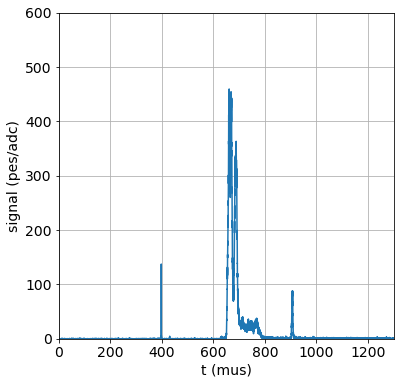

In [11]:
mpl.plot_signal_vs_time_mus(csum.csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    0,
                        signal_max =  600,
                        figsize=(6,6))

#### Raw S1 dictionary

In [12]:
pmp.S1

{0: [array([ 397725.,  397750.,  397775.,  397800.,  397825.,  397850.,
          397875.,  397900.,  397925.,  397950.,  397975.,  398000.,
          398025.,  398050.,  398075.,  398150.,  398175.,  398200.,
          398225.,  398250.,  398275.]),
  array([   8.20486639,   36.52098462,   81.26165465,  121.18487385,
          137.48255712,  125.74587346,   96.80162335,   64.45725741,
           38.77960288,   22.8160202 ,   14.28622988,   10.0269269 ,
            7.44446995,    4.62323892,    2.62474054,    2.52650981,
            3.34908875,    5.23290551,    6.11689726,    5.45412546,
            3.83782932])]}

#### Instance of S1 class

In [13]:
s1 = evm.S1(pmp.S1)

In [14]:
s1

S1(number of peaks = 1)
peak number = 0: Waveform(samples = 21 width = 550.0 ns , energy = 798.7782762218909 pes
        height = 137.48255711559008 pes tmin-tmax = minmax(min=397.725, max=398.27500000000003) mus  

In [15]:
s1.number_of_peaks

1

In [16]:
s1.peak_waveform(0)

Waveform(samples = 21 width = 550.0 ns , energy = 798.7782762218909 pes
        height = 137.48255711559008 pes tmin-tmax = minmax(min=397.725, max=398.27500000000003) mus 

In [17]:
try:
    s1.peak_waveform(2)
except PeakNotFound:
    pass
    

In [18]:
s1.peak_waveform(0).t

array([ 397725.,  397750.,  397775.,  397800.,  397825.,  397850.,
        397875.,  397900.,  397925.,  397950.,  397975.,  398000.,
        398025.,  398050.,  398075.,  398150.,  398175.,  398200.,
        398225.,  398250.,  398275.])

In [19]:
s1.peak_waveform(0).E

array([   8.20486639,   36.52098462,   81.26165465,  121.18487385,
        137.48255712,  125.74587346,   96.80162335,   64.45725741,
         38.77960288,   22.8160202 ,   14.28622988,   10.0269269 ,
          7.44446995,    4.62323892,    2.62474054,    2.52650981,
          3.34908875,    5.23290551,    6.11689726,    5.45412546,
          3.83782932])

#### Instance of s2 class

In [20]:
s2 = evm.S2(pmp.S2)

In [21]:
s2

S2(number of peaks = 5)
peak number = 0: Waveform(samples = 5 width = 4967.5 ns , energy = 338.66147032947185 pes
        height = 100.93170419418769 pes tmin-tmax = minmax(min=629.82, max=634.7875) mus  
peak number = 1: Waveform(samples = 177 width = 188303.2954545454 ns , energy = 515981.84747814573 pes
        height = 17652.774209985768 pes tmin-tmax = minmax(min=649.55125, max=837.8545454545455) mus  
peak number = 2: Waveform(samples = 5 width = 10399.25 ns , energy = 270.6932514118115 pes
        height = 64.42136606800841 pes tmin-tmax = minmax(min=845.10375, max=855.503) mus  
peak number = 3: Waveform(samples = 6 width = 13607.430555555504 ns , energy = 308.2640419659451 pes
        height = 68.18673110328308 pes tmin-tmax = minmax(min=875.448125, max=889.0555555555555) mus  
peak number = 4: Waveform(samples = 29 width = 38290.020161290304 ns , energy = 17033.244654684117 pes
        height = 3181.2063740160174 pes tmin-tmax = minmax(min=900.6906250000001, max=938.980645161

In [22]:
s2.number_of_peaks

5

In [23]:
s2.peak_waveform(4)

Waveform(samples = 29 width = 38290.020161290304 ns , energy = 17033.244654684117 pes
        height = 3181.2063740160174 pes tmin-tmax = minmax(min=900.6906250000001, max=938.9806451612903) mus 

In [ ]:
try:
    s2.peak_waveform(5)
except PeakNotFound:
    pass

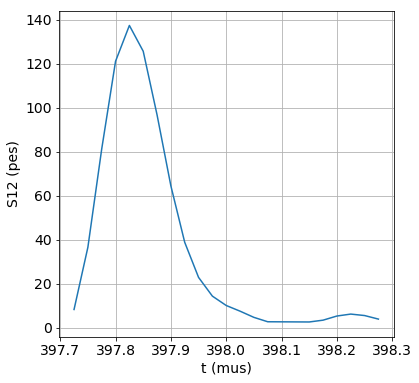

In [24]:
plot_s12(s1)

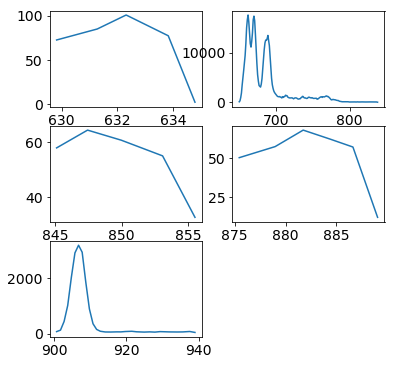

In [25]:
plot_s12(s2)

#### Raw S2Si

In [21]:
pmp.S2Si

{0: {}, 1: {336: array([  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           5.13714933,   6.85267676,   8.05989977,   7.48805729,
          13.58771037,   7.80574755,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
          

#### Instance of class S2Si

In [76]:
s2si = evm.S2Si(pmp.S2, pmp.S2Si)

In [77]:
s2si

S2Si(number of peaks = 5)
peak number = 0: Waveform(samples = 5 width = 5.0 mus , energy = 338.7 pes
        height = 100.9 pes tmin-tmax = minmax(min=629.8, max=634.8) mus  
peak number = 1: Waveform(samples = 177 width = 188.3 mus , energy = 515981.8 pes
        height = 17652.8 pes tmin-tmax = minmax(min=649.6, max=837.9) mus  
peak number = 2: Waveform(samples = 5 width = 10.4 mus , energy = 270.7 pes
        height = 64.4 pes tmin-tmax = minmax(min=845.1, max=855.5) mus  
peak number = 3: Waveform(samples = 6 width = 13.6 mus , energy = 308.3 pes
        height = 68.2 pes tmin-tmax = minmax(min=875.4, max=889.1) mus  
peak number = 4: Waveform(samples = 29 width = 38.3 mus , energy = 17033.2 pes
        height = 3181.2 pes tmin-tmax = minmax(min=900.7, max=939.0) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 1: nsipm in peak = (336, 344, 345, 346, 352, 353, 354, 360, 361, 362, 363, 368, 369, 370, 371

In [74]:
s2si.number_of_peaks

5

In [29]:
s2si.number_of_sipms_in_peak(4)

11

In [ ]:
try:
    s2si.sipms_in_peak(5)
except PeakNotFound:
    pass


In [ ]:
s2si.peak_waveform(4).E

In [ ]:
s2si.peak_waveform(4).t

In [ ]:
s2si.sipms_in_peak(4)

In [ ]:
try:
    s2si.sipms_in_peak(5)
except PeakNotFound:
    pass



In [30]:
s2si.sipm_waveform(4,1512)

Waveform(samples = 29 width = 38290.020161290304 ns , energy = 41.54734612608182 pes
        height = 12.53758101236703 pes tmin-tmax = minmax(min=900.6906250000001, max=938.9806451612903) mus 

In [31]:
s2si.sipm_waveform(4,1512).E

array([  0.        ,   0.        ,   0.        ,   6.15674158,
         6.35010035,  12.53758101,   9.63719945,   6.86572374,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ])

In [32]:
s2si.sipm_waveform_zs(4,1512)

Waveform(samples = 5 width = 4000.0 ns , energy = 41.54734612608182 pes
        height = 12.53758101236703 pes tmin-tmax = minmax(min=903.7625, max=907.7625) mus 

In [35]:
s2si.sipm_waveform_zs(4,1512).t/units.mus

array([ 903.7625,  904.7625,  905.7625,  906.7625,  907.7625])

In [34]:
s2si.sipm_waveform_zs(4,1512).E

array([  6.15674158,   6.35010035,  12.53758101,   9.63719945,   6.86572374])

In [ ]:
try:
    s2si.sipm_waveform_zs(4,1)
except SipmNotFound:
    pass

In [ ]:
try:
    s2si.sipm_waveform_zs(0,1)
except SipmEmptyList:
    print("sipm empty list")

In [ ]:
event=2
t0 = time.time()
csum, pmp = pf.compute_csum_and_pmaps(event, pmtrwf, sipmrwf, s1par, s2par, thresholds,
                        calib_vectors, deconv_params)
t1 = time.time()
dt = t1 - t0
print("compute_csum_and_pmaps in  = {} s".format(dt))
mpl.plot_signal_vs_time_mus(csum.csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    0,
                        signal_max =  600,
                        figsize=(6,6))
s1 = evm.S12(pmp.S1, s12_type="S1")
s2 = evm.S12(pmp.S2, s12_type="S2")

In [ ]:
s1

In [ ]:
s2

In [ ]:
plot_s12(s1)

In [ ]:
plot_s12(s2)

In [ ]:
h5rwf.close()

In [ ]:
filename = '/Users/jjgomezcadenas/Projects/IC/invisible_cities/database/test_data/electrons_511keV_z250_RWF.h5'
h5rwf = tb.open_file(filename, "r") 
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

In [ ]:
deconv_params = DeconvParams(n_baseline = 28000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 90 * units.mus,
                           max    = 110 * units.mus),
                           stride = 4,
                           length = minmax(min = 10, max = 30),  #250 ns -- 50 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 110 * units.mus,
                           max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 160, max = 1e6),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=3.5*units.pes,
                      thr_SIPM=20*units.pes)



In [ ]:
event=0
t0 = time.time()
csum, pmp = pf.compute_csum_and_pmaps(event, pmtrwf, sipmrwf, s1par, s2par, thresholds,
                        calib_vectors, deconv_params)
t1 = time.time()
dt = t1 - t0
print("compute_csum_and_pmaps in  = {} s".format(dt))

In [ ]:
mpl.plot_signal_vs_time_mus(csum.csum,
                        t_min      = 0,
                        t_max      = 800,
                        signal_min =    0,
                        signal_max =  300,
                        figsize=(6,6))

In [ ]:
s1 = evm.S12(pmp.S1, s12_type="S1")
s2 = evm.S12(pmp.S2, s12_type="S2")

In [ ]:
s1

In [ ]:
s2

In [ ]:
plot_s12(s1)

In [ ]:
plot_s12(s2)

In [ ]:
s1 = [i for i in range(10)]

In [ ]:
s1 = ["Hello", "World"]

In [ ]:
s1

In [ ]:
s = "Say "

In [ ]:
reduce(lambda s, x: s + x, s1, s)

In [ ]:
na

In [ ]:
x = np.isnan(na)

In [ ]:
x

In [ ]:
x.any

In [ ]:
np.any(x)

In [ ]:
y = (np.array(a) if not np.any(np.isnan(a)) else 0)

In [ ]:
y

In [ ]:
np.array([0])

In [ ]:
a = {'a':1, 'b':2}